Train: (7, 5)
Val:   (1, 5)
Test:  (2, 5)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 737 (2.88 KB)

 Trainable params: 737 (2.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - AUC: 0.0000e+00 - accuracy: 0.1429 - loss: 0.7739 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6901
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - AUC: 0.1667 - accuracy: 0.2857 - loss: 0.7430 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6821
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - AUC: 0.5417 - accuracy: 0.5714 - loss: 0.6774 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6744
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - AUC: 0.7500 - accuracy: 0.5714 - loss: 0.6701 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6663
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - AUC: 0.7917 - accuracy: 0.8571 - loss: 0.6469 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6584
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - AUC: 0.6667 - accuracy: 0.5714 - loss: 0.6622 - val_AUC: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.6504
Epoch 7/100
1/1 ━━━━━

C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


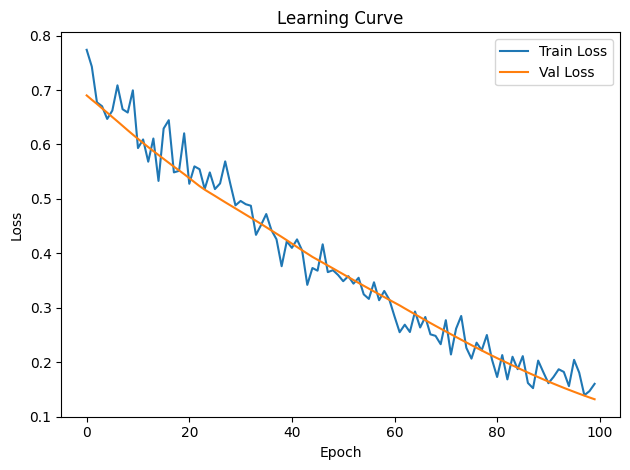

In [2]:
# -------------------------------------------------------
# Langkah 1 — Siapkan Data
# -------------------------------------------------------
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("processed_kelulusan.csv")
X = df.drop("Lulus", axis=1)
y = df["Lulus"]

sc = StandardScaler()
Xs = sc.fit_transform(X)

# Split awal (aman stratify)
X_train, X_temp, y_train, y_temp = train_test_split(
    Xs, y, test_size=0.3, stratify=y, random_state=42
)

# Cek apakah kelas cukup untuk stratify kedua
if y_temp.value_counts().min() > 1:
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
else:
    # fallback tanpa stratify
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


# -------------------------------------------------------
# Langkah 2 — Bangun Model ANN
# -------------------------------------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")  # klasifikasi biner
])

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="binary_crossentropy",
              metrics=["accuracy","AUC"])
model.summary()


# -------------------------------------------------------
# Langkah 3 — Training dengan Early Stopping
# -------------------------------------------------------
es = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100, batch_size=16,
    callbacks=[es], verbose=1
)


# -------------------------------------------------------
# Langkah 4 — Evaluasi di Test Set
# -------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix

loss, acc, auc = model.evaluate(X_test, y_test, verbose=0)
print("Test Acc:", acc, "AUC:", auc)

y_proba = model.predict(X_test).ravel()
y_pred = (y_proba >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


# -------------------------------------------------------
# Langkah 5 — Visualisasi Learning Curve
# -------------------------------------------------------
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.title("Learning Curve")
plt.tight_layout()
plt.savefig("learning_curve.png", dpi=120)
